In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [712]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import starry
from scipy.special import legendre as P
from scipy.optimize import minimize
from matplotlib import patches

starry.config.quiet = True

In [646]:
def hwhm(rprime):
    """
    Return the half-width at half minimum as a function of r'.
    
    """
    return np.arccos((2 + 3 * rprime * (2 + rprime)) / (2 * (1 + rprime) ** 3)) * 180 / np.pi

In [647]:
def peak_error(ydeg, rprime):
    """
    Returns the error in the intensity at the spot center.
    
    """
    delta = 1.0
    I = (1 - 0.5 * delta * rprime / (1 + rprime))
    for l in range(1, ydeg + 1):
        I -= 0.5 * delta * rprime * (2 + rprime) / (1 + rprime) ** (l + 1)
    return np.abs(I)

In [656]:
def min_rprime(ydeg, tol=1e-2):
    f = lambda rprime: (peak_error(ydeg, rprime) - tol) ** 2
    res = minimize(f, 0.25)
    return res.x

In [659]:
def max_rprime(hmwhm_max=75):
    f = lambda rprime: (hwhm(rprime) - hmwhm_max) ** 2
    res = minimize(f, 10)
    return res.x

In [682]:
max_rprime()

array([4.7368567])

In [668]:
def get_c(ydeg, tol=1e-2, hwhm_max=75):
    rmin = min_rprime(ydeg, tol=tol)
    rmax = max_rprime(hmwhm_max=hwhm_max)
    c0 = rmin
    c1 = rmax - rmin
    return c0, c1

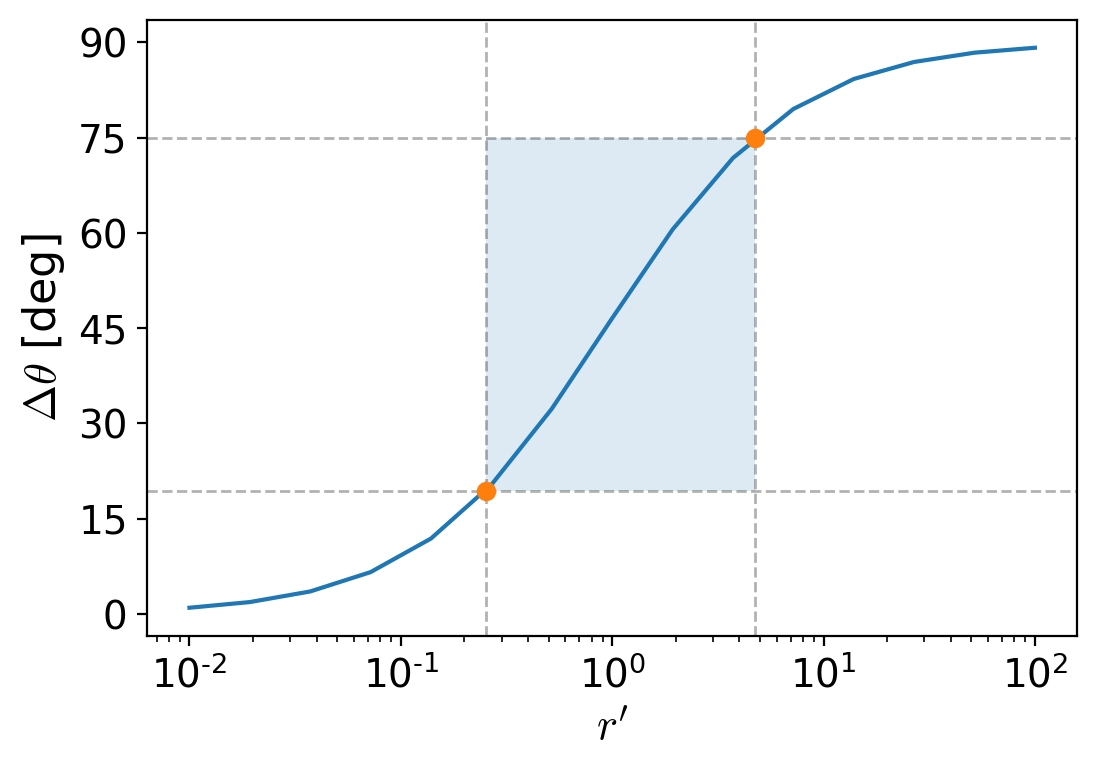

In [717]:
r = np.logspace(-2, 2, 15)
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(r, hwhm(r))
ax.set_yticks([0, 15, 30, 45, 60, 75, 90])
ax.set_xlabel(r"$r'$", fontsize=16)
ax.set_ylabel(r"$\Delta\theta$ [deg]", fontsize=16)
ax.set_xscale("log")

# Maximum (max_hwhm = 75 degrees)
max_hwhm = 75.0
max_r = max_rprime(max_hwhm)
ax.axhline(max_hwhm, color="k", lw=1, ls="--", alpha=0.3)
ax.axvline(max_r, color="k", lw=1, ls="--", alpha=0.3)
ax.plot(max_r, max_hwhm, "C1o")

# Minimum (ydeg = 20, tol=1e-2)
min_r = min_rprime(20, tol=1e-2)
min_hwhm = hwhm(min_r)
ax.axhline(min_hwhm, color="k", lw=1, ls="--", alpha=0.3)
ax.axvline(min_r, color="k", lw=1, ls="--", alpha=0.3)
ax.plot(min_r, min_hwhm, "C1o")

ax.add_patch(
    patches.Rectangle(
        (min_r, min_hwhm),
        max_r - min_r,
        max_hwhm - min_hwhm,
        linewidth=1,
        edgecolor="none",
        facecolor="C0",
        alpha=0.15,
    )
);

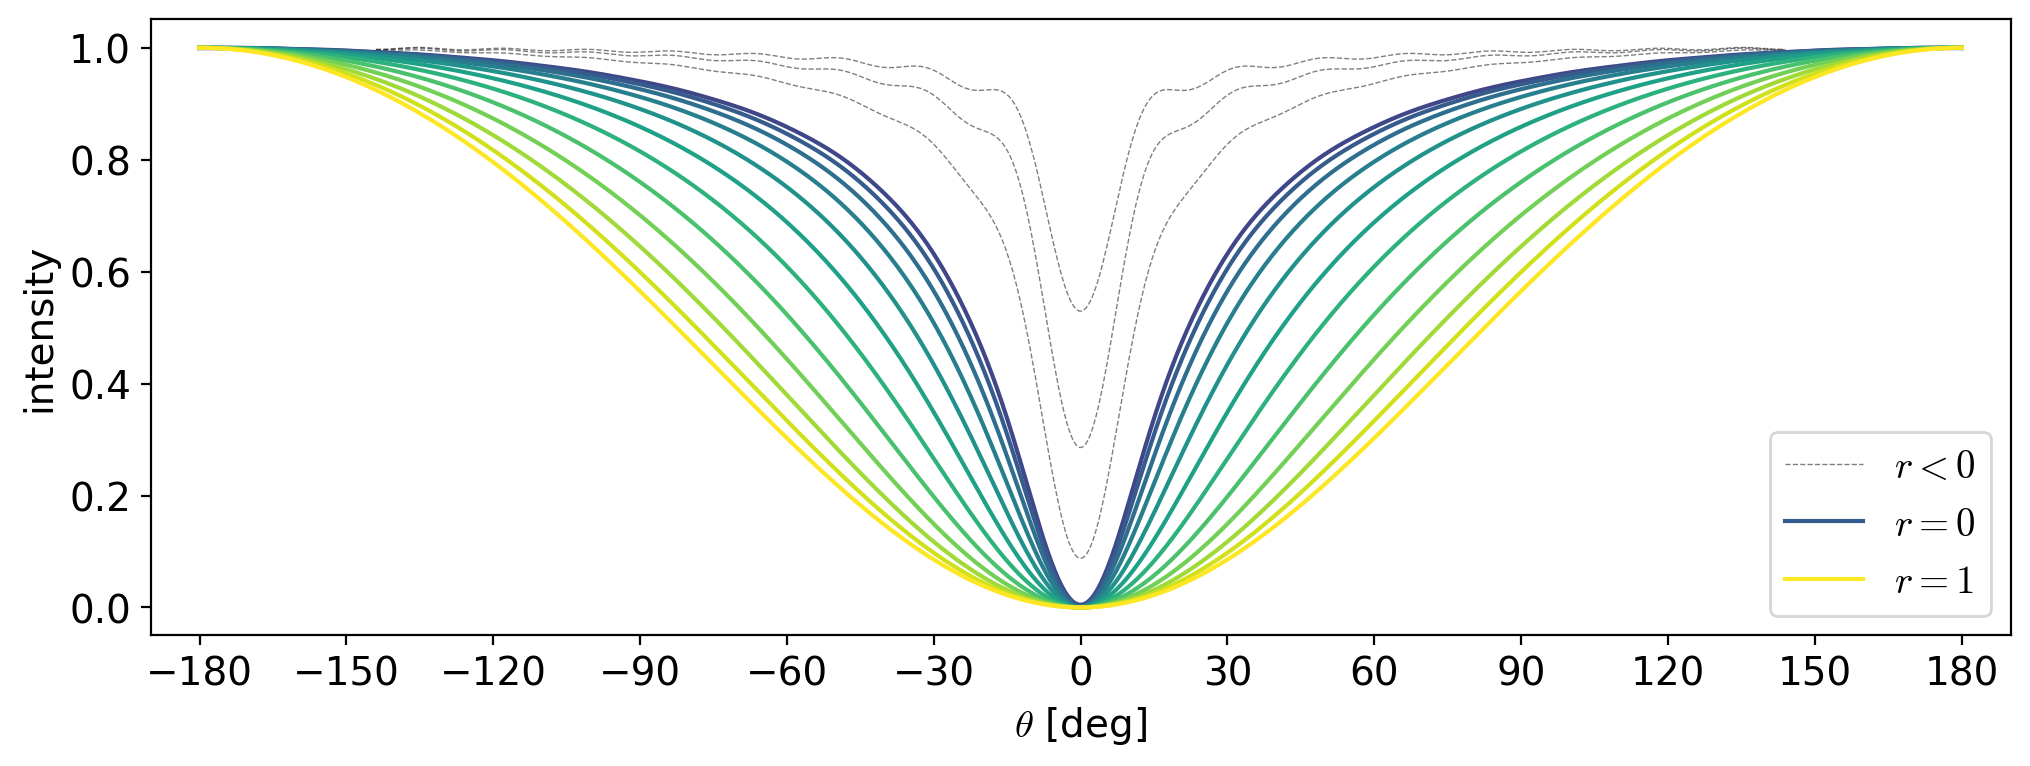

In [680]:
ydeg = 20
map = starry.Map(ydeg, lazy=False)
r = np.logspace(-2, 1, 15)

c0, c1 = get_c(ydeg)
rprime = c0 + c1 * r

rprime = np.append([c0 / 8, c0 / 4, c0 / 2], rprime)

delta = 1
lon = np.linspace(-180, 180, 1000)
l = np.arange(1, map.ydeg + 1)

fig, ax = plt.subplots(1, figsize=(12, 4))
cmap = plt.get_cmap("viridis")
for k in range(len(r)):
    x = np.zeros(map.Ny)
    x[0] = 1 - 0.5 * delta * rprime[k] * (1 + rprime[k]) ** -1
    x[l * (l + 1)] = (
        -delta
        / np.sqrt(2 * l + 1)
        * (
            (1 + rprime[k]) ** -(l + 1) * rprime[k]
            + 0.5 * (1 + rprime[k]) ** -(l + 1) * rprime[k] ** 2
        )
    )
    map[:, :] = x
    if k < 3:
        if k == 0:
            label = r"$r < 0$"
        else:
            label = None
        ax.plot(
            lon[100:-100],
            np.pi * map.intensity(lon=lon[100:-100]),
            "k--",
            lw=0.5,
            alpha=0.5,
            label=label,
        )
    else:
        if k == 4:
            label = r"$r = 0$"
        elif k == len(r) - 1:
            label = r"$r = 1$"
        else:
            label = None
        ax.plot(
            lon,
            np.pi * map.intensity(lon=lon),
            color=cmap(k / (len(r) - 1)),
            label=label,
        )

ax.set_xlim(-190, 190)
ax.set_xticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
ax.set_xlabel(r"$\theta$ [deg]")
ax.set_ylabel(r"intensity")
ax.legend(loc="lower right");

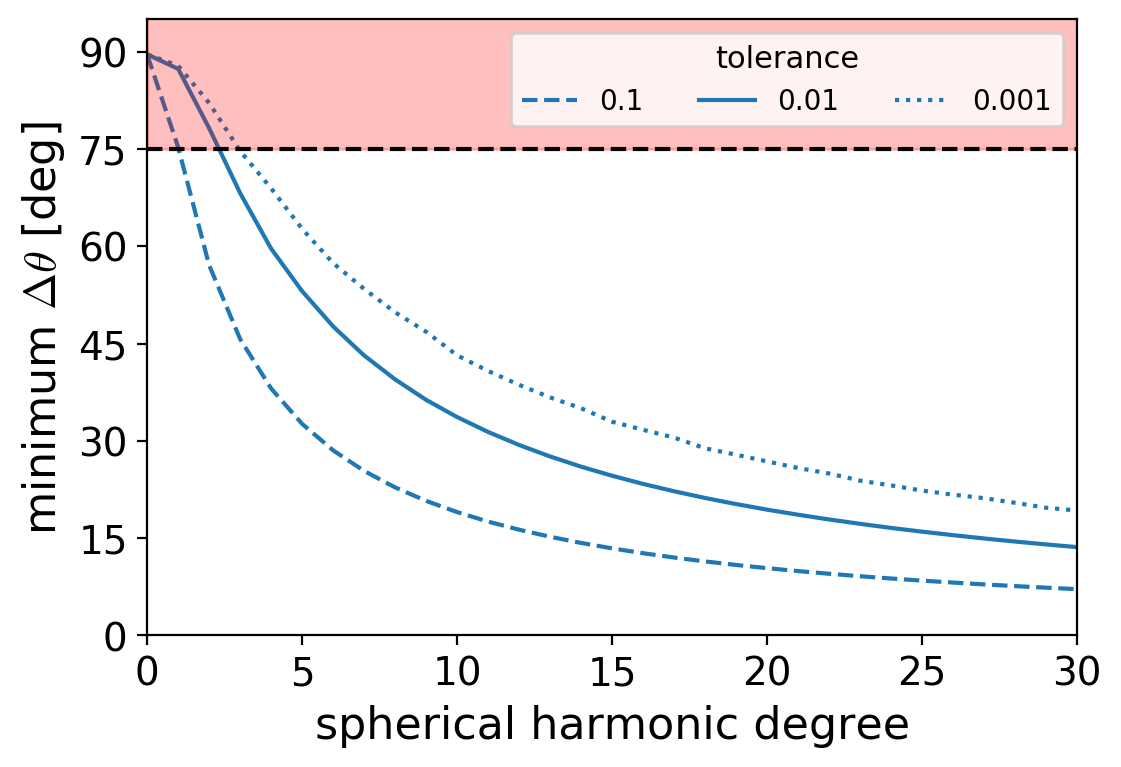

In [706]:
fig, ax = plt.subplots(1, figsize=(6, 4))

l = np.arange(0, 31, dtype=int)
for tol, style in zip([1e-1, 1e-2, 1e-3], ["C0--", "C0-", "C0:"]):
    r = hwhm(np.array([min_rprime(ydeg, tol=tol) for ydeg in l]))
    plt.plot(l, r, style, label=tol, zorder=-1)
legend = ax.legend(loc="upper right", fontsize=10, title=r"tolerance", ncol=3)
plt.setp(legend.get_title(), fontsize=11)
ax.axhline(75, color="k", ls="--")
ax.axhspan(75, 100, color="r", alpha=0.25)
ax.set_ylim(0, 95)
ax.set_xlim(0, 30)
ax.set_yticks([0, 15, 30, 45, 60, 75, 90]);
ax.set_xlabel("spherical harmonic degree", fontsize=16)
ax.set_ylabel(r"minimum $\Delta\theta$ [deg]", fontsize=16);